For this program, I am using KNN algorithm to classify the dataset into 36 group.
And use the outcome from KNN to create the edges between the nodes.
Then using created GNN model, nodes and edges to train the GNN.
Finally, using Accuarcy, Precision, Recall Score, F1 Score to evaluate the performance.

In [1]:
import lime
import torch
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import lime.lime_tabular
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
## Create GNN Model
class GCNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim = 1)

# Convert your torch model's prediction to work with LIME
def gnn_predict_proba(data):
    # data here is expected to be a numpy array for compatibility with LIME
    data_tensor = torch.tensor(data, dtype=torch.float)
    edge_index = torch.tensor([[i, j] for i in range(data_tensor.shape[0]) for j in range(data_tensor.shape[0])], dtype=torch.long).t().contiguous()
    output = model(Data(x=data_tensor, edge_index=edge_index))
    # Converting log probabilities to probabilities for LIME
    proba = F.softmax(output, dim=1).detach().numpy()
    return proba
    
def visualize_subgraph(edge_index, num_nodes=30):
    """
    Visualize a subgraph consisting of 'num_nodes' nodes and their corresponding edges.
    
    Parameters:
    - edge_index: Tensor of shape (2, num_edges), representing the edges of the full graph.
    - num_nodes: The number of nodes to include in the subgraph.
    """
    ## Create a null graph of NetworkX
    G = nx.Graph()

    ## Put the node into the graph
    G.add_nodes_from(range(num_nodes))

    ## According to the number of nodes in the graph, adding the edges into it
    for i, j in edge_index.t().tolist():
        if i < num_nodes and j < num_nodes:
            G.add_edge(i, j)

    ## Plot it
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.title(f'Subgraph with {num_nodes} Nodes')
    plt.show()

# Generate a complete edge index for a fully connected graph
def create_edge_index(data):
    ## Initialize and train KNN model
    knn = NearestNeighbors(n_neighbors = 2, algorithm = 'auto').fit(data)

    ## Find the nearest neighbour index for every nodes
    distances, indices = knn.kneighbors(data)

    ## Define the edges for GNN
    edges = []
    for i in range(len(data)):
        for j in indices[i]:
            if i != j:
                edges.append([i, j])

    return torch.tensor(edges, dtype=torch.long).t().contiguous()

In [3]:
'''
This step is to load the data and extract the features and labels.
'''
## Loading the Data
InputData = pd.read_csv('Data/Dataset_spine_clean.csv')

## Extract the features of spine data
node_features = torch.tensor(InputData.iloc[:, 1:13].values, dtype=torch.float)

## Getting the state label
labels_string = InputData.iloc[:, 13].values
labels = torch.tensor([1 if label == 'Normal' else 0 for label in labels_string], dtype=torch.long)

'''
Using K-Nearest Neighbour to classify the relationship between each dataset.
Then using this to define the edges using in the GNN model.
Split the dataset first. So I can create the edges based on training or testing data.
Since the edges need to be create both properly on train data and test data.
'''
## Transform the features matrix into the correct format for KNN algorithm
node_features_np = node_features.numpy()

## Splitting
X_train, X_test, y_train, y_test = train_test_split(node_features_np, labels,
                                                    test_size = 0.2, random_state = 42)

## Convert the edges list into PyTorch Tensor
train_edge_index = create_edge_index(X_train)
test_edge_index = torch.tensor([[i, i] for i in range(len(X_test))], dtype = torch.long).t().contiguous()
##test_edge_index = create_edge_index(X_test)

train_data = Data(x = torch.tensor(X_train, dtype=torch.float), edge_index = train_edge_index, y = y_train)
test_data = Data(x = torch.tensor(X_test, dtype=torch.float), edge_index = test_edge_index, y = y_test)

In [4]:
'''
For this step, I am going to train the GNN model
'''
model = GCNModel(num_node_features = 12, num_classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Define the list to contain the loss for visualizing step
loss_values = []

## Training
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.nll_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 8.663155555725098
Epoch 2, Loss: 8.290571212768555
Epoch 3, Loss: 7.921640396118164
Epoch 4, Loss: 7.56129264831543
Epoch 5, Loss: 7.206066131591797
Epoch 6, Loss: 6.856645584106445
Epoch 7, Loss: 6.513548374176025
Epoch 8, Loss: 6.186732292175293
Epoch 9, Loss: 5.8861775398254395
Epoch 10, Loss: 5.610568046569824
Epoch 11, Loss: 5.35615348815918
Epoch 12, Loss: 5.124575138092041
Epoch 13, Loss: 4.921859264373779
Epoch 14, Loss: 4.752319812774658
Epoch 15, Loss: 4.607173442840576
Epoch 16, Loss: 4.475430011749268
Epoch 17, Loss: 4.351795673370361
Epoch 18, Loss: 4.231768608093262
Epoch 19, Loss: 4.110829830169678
Epoch 20, Loss: 3.984649419784546
Epoch 21, Loss: 3.855185031890869
Epoch 22, Loss: 3.720757484436035
Epoch 23, Loss: 3.5830037593841553
Epoch 24, Loss: 3.443363904953003
Epoch 25, Loss: 3.301666736602783
Epoch 26, Loss: 3.1590795516967773
Epoch 27, Loss: 3.019249439239502
Epoch 28, Loss: 2.8862009048461914
Epoch 29, Loss: 2.7577459812164307
Epoch 30, Loss: 2.63

In [5]:
## Evaluation
model.eval()
_, pred = model(test_data).max(dim = 1)
test_pred = pred.numpy()

test_accuarcy = accuracy_score(y_test, test_pred)
print(f'Test Accuarcy: {test_accuarcy:.4f}')

test_precision = precision_score(y_test, test_pred, average='macro')
print(f'Test Precision: {test_precision:.4f}')

test_recall = recall_score(y_test, test_pred, average='macro')
print(f'Test Recall: {test_recall:.4f}')

test_f1 = f1_score(y_test, test_pred, average='macro')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuarcy: 0.7903
Test Precision: 0.7458
Test Recall: 0.7374
Test F1 Score: 0.7413


For this step, I am going to visualize the training process and the evaluation score.

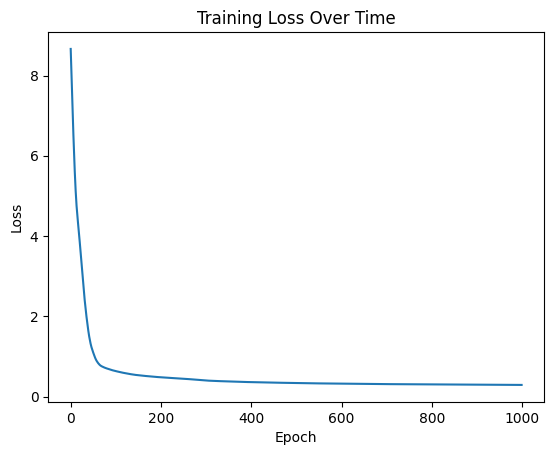

In [6]:
## Plot the loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

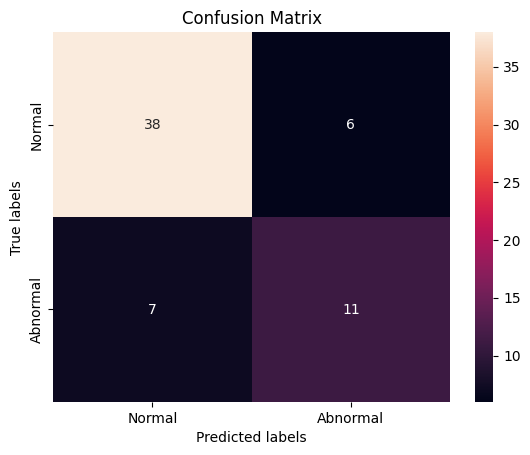

In [7]:
## Plot the confusion matrix
cm = confusion_matrix(y_test.numpy(), pred.numpy())
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

For this step, I am going to visualize the GNN model by plot.
This is still very simple graph. Need more improvement.

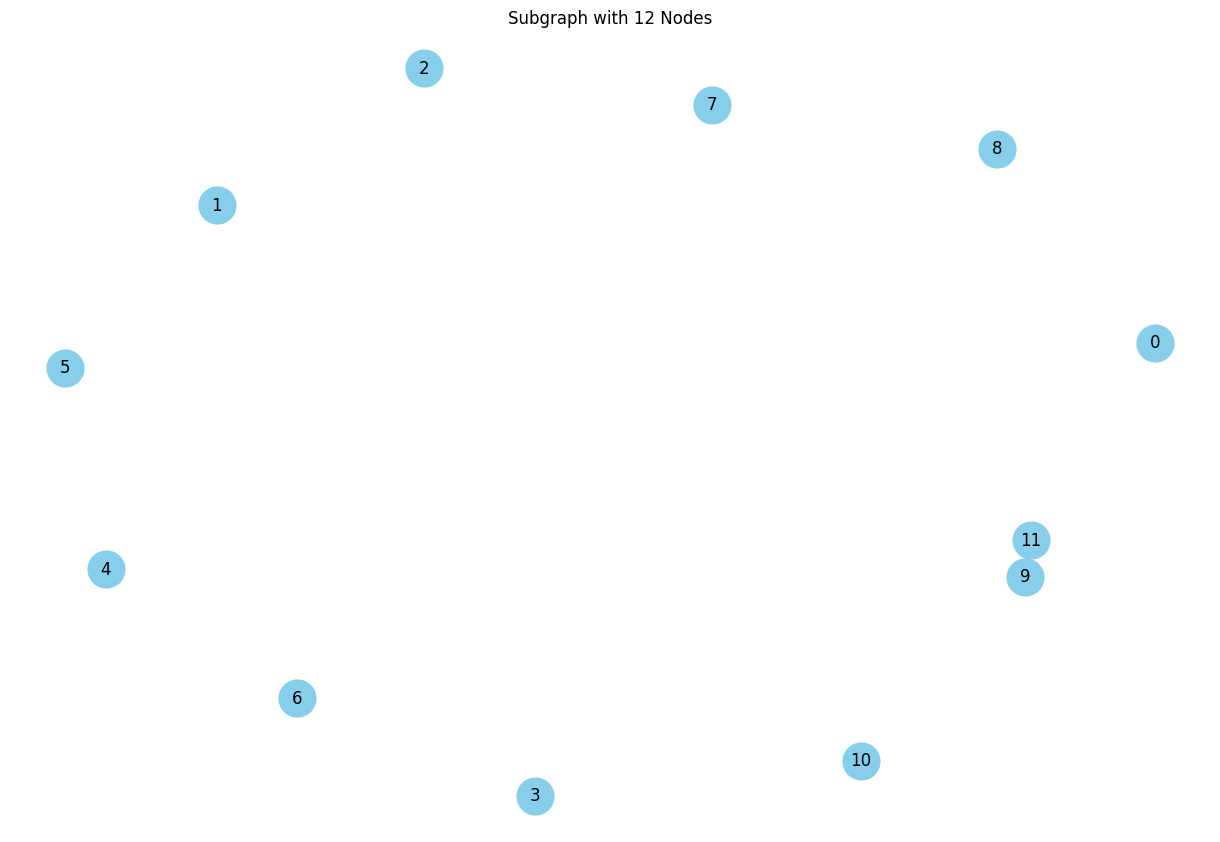

In [8]:
# Input the number of nodes and the related edges, then visulize the nural network
visualize_subgraph(train_edge_index, num_nodes=12)

For the following step, I am going to plot Receiver Operating Characteristic (ROC).
And compute Area Under Curve (AUC) for evaluate the performance of my model

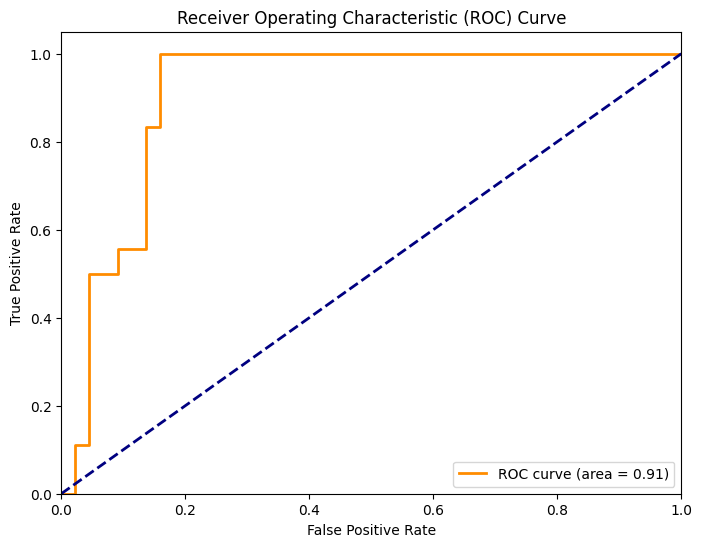

In [9]:
# Probability of prediction
pred_probs = torch.softmax(model(test_data).detach(), dim=1)[:, 1].numpy()

# Compute the ROC
fpr, tpr, thresholds = roc_curve(y_test.numpy(), pred_probs)

# Calculating the AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Using LIME algorithm to explan the prediction

In [10]:
# Prepare the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.astype(float),  # Ensure the data is float
    feature_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                     "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                     "sacrum_angle", "scoliosis_slope"],
    class_names=['Normal', 'Abnormal'],
    mode='classification'
)

# Choose an instance to explain
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test[i].astype(float), gnn_predict_proba, num_features = 12)

# Display the explanation in the notebook
exp.show_in_notebook(show_table=True, show_all=False)

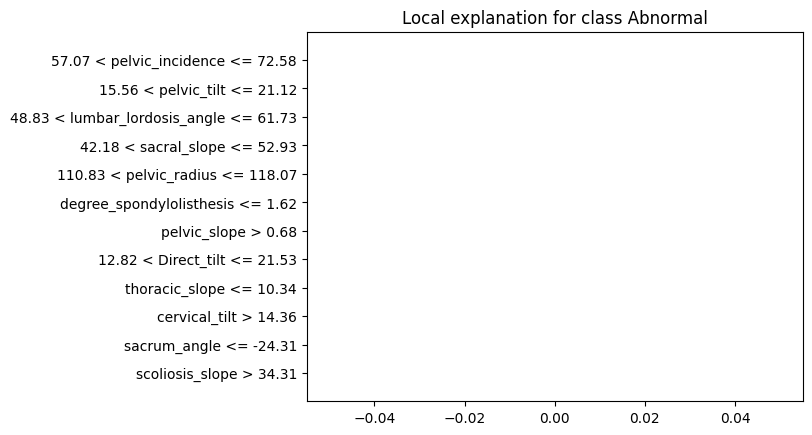

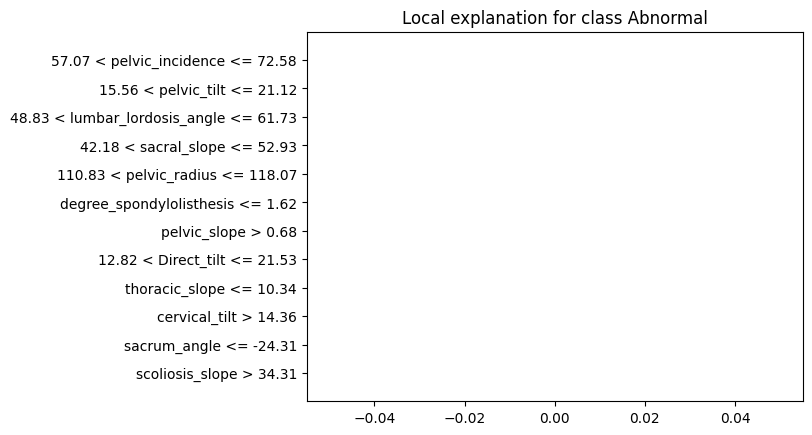

In [11]:
exp.as_pyplot_figure()